# 0.0 Modules, etc.

In [1]:
import numpy as np
import pandas as pd
import multiprocessing

import scipy
from scipy import spatial
from scipy.spatial import cKDTree

import sklearn as sk
from sklearn import svm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import clone
from sklearn.externals.six.moves import xrange

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

Loading BokehJS ...

In [2]:
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

In [ ]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
# plotly.tools.set_credentials_file(username='duplinskiy', api_key='RsZHhxIiAGGu7FN9P4bu')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

cf.go_offline()

### Article Reference Data

In [ ]:
# dat_ref.to_csv('dat_ref.csv')

dat_ref = pd.read_csv('dat_ref.csv', low_memory=False, index_col = 0) 
# dat_ref = dat_ref[dat_ref['retail_intro_date_global'] != '0']

### Note: key article -- C77124

In [ ]:
dat[dat['article_number'] == 'C77124']


    - Small: < 100 units
    - Large: > 30000 units

### Exasol

In [ ]:
import pyexasol
from pyexasol import ExaConnection

# Id: comischr
# Pwd: Comiskey021

C = pyexasol.connect(dsn='10.143.86.51:8583', user='comischr', password='Comiskey021', compression=True, encryption=True)
dfAndreasDistances = C.export_to_pandas("""select * from READ_SCV.PPC_SIM_ARTICLEPAIR_EUCL_V where EUCL_SCORE < 7.8 / 2""")


### Historical raw MAPE

In [ ]:
%%time

carryover = pd.read_csv('Stock left and of season.csv', low_memory=False, index_col = 0)
                                          # usecols=['season', 'article_number', 'ecom_available_stock']) 

carryover.reset_index(inplace = True)

In [ ]:
# dat0 = pd.read_csv('dat.csv', low_memory=False, index_col = 0) # Wall time: 1min 47s

In [ ]:
dat = dat0.copy()

In [ ]:
dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

dat = dat[dat['gross_demand_quantity'] != 0] 
dat.drop(['sales_organization', 'country', 'brand', 'sold_qty', 'std_margin', 
          'return_qty', 'article_promotion_main_category_group', 'fw_or_ss'], 
         inplace=True, axis = 1)

dat = dat.groupby(by = ['article_number', 'season']).agg('sum')[['net_qty']] # aggregate by year
dat.reset_index(inplace=True)


In [ ]:
dat = pd.merge(dat, carryover, left_on=['article_number', 'season'], right_on=['article_number', 'season'])

In [ ]:
# multiple ecom_available_stock on accident; so find min
dat1 = (
    pd.DataFrame(dat.groupby(['article_number', 'season'])['ecom_available_stock'].min()).
    reset_index())

# leftover was 0, so understocked (maybe, unless sold leftovers)
dat_understock = dat1[dat1['ecom_available_stock'] == 0]


In [ ]:
dat2 = (pd.merge(dat1, dat, how = 'left').
        drop_duplicates()
       )
dat2 = dat2[dat2['season'] != 'SS19']

In [ ]:
dat2 = dat2[(dat2['net_qty'] != 0) & (dat2['ecom_available_stock'] != 0)]


In [ ]:
# pct error = [forecast - actual]/actual = (net_qty + stock - net_qty)/net_qty
dat2['percent_error'] = dat2['ecom_available_stock']/dat2['net_qty']*100

In [ ]:
bins = [0, 100, 1000, 30000]
dat2['bin'] = pd.cut(np.array(dat2['net_qty']), bins)

# ---- Similarity-based prediction, by bin ----
# kahuna_ref.groupby('bin')['Pct_Err'].describe()[['count', 'mean']]

In [ ]:
d = dat2.groupby(['season', 'bin'])['percent_error'].describe()[['count', 'mean', '50%']]

In [ ]:
# --- Sort by season ---

order = {'SS17': 0, 'FW17': 1, 'SS18': 2, 'FW18': 3, 'SS19': 4}
d['order_id'] = [order[i] for i in d.reset_index()['season']]

d.sort_values(by = ['order_id', 'bin'], inplace=True)
d.drop('order_id', axis = 1, inplace=True)

In [ ]:
d.round().astype('int')

# Corrected-MAPE

### Annual Stockout EDA

In [ ]:
carryover = pd.read_csv('Stock left and of season.csv', low_memory=False, index_col = 0, 
                        usecols=['season', 'article_number', 'ecom_available_stock', 'buy_availability']) 

carryover = (
    pd.DataFrame(carryover.groupby(['article_number', 'season'])['ecom_available_stock'].min()).reset_index()
)

In [ ]:
dat0 = pd.read_csv('dat.csv', low_memory=False, index_col = 0) # Wall time: 1min 47s

In [ ]:
dat = dat0.copy()

In [ ]:
# aggregate to article-season net_qty
dat = dat.groupby(by = ['article_number', 'season']).agg('sum')[['net_qty']] # aggregate by season
dat.reset_index(inplace=True)

# Add end of season stock information
dat = pd.merge(dat, carryover, left_on=['article_number', 'season'], right_on=['article_number', 'season'])

# leftover was 0, so understocked (maybe, unless sold leftovers)
dat_understock = dat[dat['ecom_available_stock'] == 0]

# remove current season
dat_understock = dat_understock[dat_understock['season'] != 'SS19']

# remove small potatoes items
dat_understock = dat_understock[dat_understock['net_qty'] > 100]

In [ ]:
# --- Sort & order by season ---

bins = [0, 100, 200, 500, 1000, 2000, 5000, 10000, 30000]
dat_understock['bin'] = pd.cut(np.array(dat_understock['net_qty']), bins)

d = pd.DataFrame(dat_understock.groupby(['season', 'bin'])['article_number'].describe()['count'])


order = {'SS17': 0, 'FW17': 1, 'SS18': 2, 'FW18': 3, 'SS19': 4}
d['order_id'] = [order[i] for i in d.reset_index()['season']]

d.sort_values(by = ['order_id', 'bin'], inplace=True)
d.drop('order_id', axis = 1, inplace=True)

In [ ]:
stockouts = dat_understock['article_number'].unique()

### C-MAPE EDA

In [ ]:
# end-of-season stock information
carryover = pd.read_csv('Stock left and of season.csv', low_memory=False, index_col = 0, 
                        usecols=['season', 'article_number', 'ecom_available_stock', 'buy_availability']) 

# Remove pseudo-duplicates: multiple ecom_available_stock on accident, so find min
carryover = (
    pd.DataFrame(carryover.groupby(['article_number', 'season'])['buy_availability'].min()).
    reset_index())

In [ ]:
# buy_availability
stockouts = carryover[carryover['buy_availability'] < .35] 

# SS18 stockouts
SS18stockouts = stockouts[stockouts['season'] == 'SS18']

In [ ]:
dat0 = pd.read_csv('dat.csv', low_memory=False, index_col = 0) 
dat0['consumer_order_date'] = pd.to_datetime(dat0['consumer_order_date'])

In [ ]:
dat = dat0.copy()

dat = dat[dat['net_qty'] != 0] 
dat.drop(['sales_organization', 'country', 'brand', 'sold_qty', 'gross_demand_quantity', 'net_sales', 
          'std_margin', 'return_qty', 'article_promotion_main_category_group', 'fw_or_ss'], 
         inplace=True, axis = 1)

In [ ]:
# SS18 data
SS18dat = dat[dat['season'] == 'SS18']

# ----- SS18 articles with large net_qty -----
bigSS18articles = pd.DataFrame(SS18dat.groupby(['article_number']).agg('sum')['net_qty']).reset_index()
bigSS18articles = pd.Series(bigSS18articles[bigSS18articles['net_qty'] > 1000]['article_number'].unique())

# ----- SS18 articles with net_qty > 1000 **AND** stockout -----
bigSS18stockout_list = list(set(bigSS18articles).intersection(set(SS18stockouts['article_number'])))

In [ ]:
from random import sample 

samp = sample(bigSS18stockout_list, 5)
bigSS18stockout_dat = SS18dat[[x in samp for x in SS18dat['article_number']]]

bigSS18stockout_dat = bigSS18stockout_dat.groupby(by = ['article_number', 'consumer_order_date']) # grouped by article-date
bigSS18stockout_dat = pd.DataFrame(bigSS18stockout_dat.agg('sum')['net_qty']) # net_qty by article, order date
bigSS18stockout_dat.reset_index(inplace=True)

# resample to weekly
bigSS18stockout_dat.set_index('consumer_order_date', inplace = True)
bigSS18stockout_dat = bigSS18stockout_dat.groupby('article_number').resample('W').sum()
bigSS18stockout_dat.reset_index(inplace=True)


In [ ]:
# --- plots ---

bigSS18stockout_dat['total_sales'] = bigSS18stockout_dat['net_qty'].cumsum()

pivoted = bigSS18stockout_dat.pivot(index = 'consumer_order_date', 
                                  columns = 'article_number', 
                                  values = 'net_qty')

pivoted2 = bigSS18stockout_dat.pivot(index = 'consumer_order_date', 
                                  columns = 'article_number', 
                                  values = 'total_sales')

plt.rcParams["figure.figsize"] = [9,4]

pivoted.plot()
pivoted2.plot()

### Buy Availability Plot

In [ ]:
# buy_availability by week

buy_avail = pd.read_csv('stock data per week and per article.csv', low_memory=False)
buy_avail['min_date_of_week'] = pd.to_datetime(buy_avail['min_date_of_week'])

In [ ]:
buy_avail = buy_avail[['article_number', 'min_date_of_week', 'avg(ecom_available_stock)', 'avg(buy_availability)']]

In [ ]:
buy_avail_stockouts = buy_avail[[x in bigSS18stockout_list for x in buy_avail['article_number']]] # Wall time: 17.2 s

In [ ]:
buy_avail_stockouts['week'] = [t.week for t in buy_avail_stockouts['min_date_of_week']]
bigSS18stockout_dat['week'] = [t.week for t in bigSS18stockout_dat['consumer_order_date']]

In [ ]:
SS18min = SS18dat['consumer_order_date'].min()
SS18max = SS18dat['consumer_order_date'].max()

buy_avail_stockouts = buy_avail[
    (buy_avail['min_date_of_week'] > SS18min) & 
    (buy_avail['min_date_of_week'] < SS18max)]


In [ ]:
# --- plot ---
samp = sample(bigSS18stockout_list, 5)
buy_avail_samp = buy_avail[[x in samp for x in buy_avail['article_number']]]

pivoted = buy_avail_samp.pivot(index = 'min_date_of_week', 
                                  columns = 'article_number', 
                                  values = 'avg(buy_availability)')

plt.rcParams["figure.figsize"] = [12,5]

pivoted.plot()

### C-MAPE: understock

In [ ]:
# dat = pd.read_csv('dat.csv', low_memory=False, index_col = 0) 
# dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])
# dat = dat[dat['net_qty'] != 0] 
# dat = dat[dat['season'] != 'SS19']
# dat.drop(['sales_organization', 'country', 'brand', 'sold_qty', 'gross_demand_quantity', 'net_sales', 'std_margin', 'return_qty', 'article_promotion_main_category_group', 'fw_or_ss'], inplace=True, axis = 1)

# dat.set_index('consumer_order_date', inplace = True)
# dat = dat.groupby(['article_number', 'season']).resample('W').sum() # 'aggregate' to weekly sums by article
# dat.reset_index(inplace=True)

In [ ]:
%%time

# dat.to_csv('weekly_dat.csv')
dat = pd.read_csv('weekly_dat.csv', low_memory=False, index_col = 0) # Wall time: 10.9 s
dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

In [ ]:
# Wall time: 26.5 s

dat['week'] = [t.week for t in dat['consumer_order_date']]
dat['year'] = [t.year for t in dat['consumer_order_date']]

# buy_avail = pd.read_csv('stock data per week and per article.csv', low_memory=False)
# buy_avail['min_date_of_week'] = pd.to_datetime(buy_avail['min_date_of_week'])
# buy_avail = buy_avail[['article_number', 'min_date_of_week', 'avg(buy_availability)']]
# buy_avail['week'] = [t.week for t in buy_avail['min_date_of_week']]
# buy_avail['year'] = [t.year for t in buy_avail['min_date_of_week']]

# buy_avail.to_csv('buy_availability.csv')
buy_avail = pd.read_csv('buy_availability.csv', low_memory=False, index_col = 0)

# dat[(dat['article_number'] == '001354') & (dat['year'] == 2017)].loc[[0,65],:]
# buy_avail[(buy_avail['article_number'] == '001354') & (buy_avail['year'] == 2017)]

In [ ]:
dat = pd.merge(dat, buy_avail, 
                left_on = ['article_number', 'year', 'week'], 
                right_on = ['article_number', 'year', 'week'])

In [ ]:
# Add indicator for buy availability > 0.35
dat['stockout_indicator'] = dat['avg(buy_availability)'] < 0.35
# dat['stockout_indicator'].mean() # 0.1706

In [ ]:
season_dat = pd.DataFrame(
    dat.
    groupby(['article_number', 'season'])['net_qty'].
    sum()
)

# Season averages for articles when fully stocked
stocked = pd.DataFrame(
    dat[dat['stockout_indicator'] == False].
    groupby(['article_number', 'season'])['net_qty'].
    mean()
)

stocked['season_projected'] = 26*stocked['net_qty']

season_dat = (
    pd.merge(season_dat, stocked, left_index=True, right_index=True, how = 'outer').
    rename(columns = {'net_qty_y':'daily_available_avg', 'net_qty_x':'season_actual'})
)

del stocked

In [ ]:
preds = (pd.DataFrame(
    pd.read_csv('Buyers predictions.csv', low_memory=False, index_col = 0))
         [['season', 'ecom_marketing_forecast']].
         reset_index().
        dropna())

season_dat = pd.merge(
    season_dat, 
    preds, 
    left_index=True, 
    right_on=['article', 'season'], 
    how = 'outer').round().set_index(['article', 'season'])

season_dat['season*'] = season_dat[['season_projected', 'season_actual']].max(axis = 1)
season_dat['APE'] = abs(season_dat['season*'] - season_dat['ecom_marketing_forecast'])/season_dat['season*']*100

season_dat.reset_index(inplace = True)
season_dat.dropna(inplace = True)

del preds

In [ ]:
bins = [0, 100, 1000, 30000]
season_dat['bin'] = pd.cut(np.array(season_dat['season*']), bins)

d = season_dat.groupby(['season', 'bin'])['APE'].describe()[['count', 'mean', '50%']]

# --- Sort by season ---

order = {'SS17': 0, 'FW17': 1, 'SS18': 2, 'FW18': 3, 'SS19': 4}
d['order_id'] = [order[i] for i in d.reset_index()['season']]

d.sort_values(by = ['order_id', 'bin'], inplace=True)
d.drop('order_id', axis = 1, inplace=True)

d.round()

In [51]:
%whos DataFrame 

Variable           Type         Data/Info
-----------------------------------------
dat                DataFrame             consumer_order_d<...>8870514 rows x 5 columns]
dat1               DataFrame                             <...>1583437 rows x 1 columns]
dat2               DataFrame                           ne<...>03-17            0.640498
dat_both           DataFrame                         With<...>640498           0.628745
dat_wo_clearance   DataFrame                           ne<...>03-17            0.628745


### C-MAPE: Overstock

In [ ]:
# clearance = pd.read_csv('Sale Data/Sale data FW17.csv', low_memory=False, index_col = 0) 

# clearance = clearance.reset_index() # groupby('article_number').resample('W')
# clearance['consumer_order_date'] = pd.to_datetime(clearance['consumer_order_date'])
# clearance.set_index('consumer_order_date', inplace=True)

In [ ]:
dat0 = pd.read_csv('dat.csv', low_memory=False, index_col = 0) # Wall time: 1min 47s

In [ ]:
dat0['article_promotion_main_category_group'].value_counts()

In [ ]:
# Johannes said 'SALE' is Clearance, and outlet won't contribute much
SALE = dat0[dat0['article_promotion_main_category_group'] == 'SALE']

In [ ]:
SALE['consumer_order_date'] = pd.to_datetime(SALE['consumer_order_date'])
SALE.set_index('consumer_order_date', inplace = True)

In [ ]:
SALE2 = SALE[['article_number', 'season', 'net_qty']].groupby(['article_number', 'season']).resample('W').sum() # 'aggregate' to weekly sums by article
SALE2.reset_index(inplace=True)

In [ ]:
plt.rcParams["figure.figsize"] = [18,4]

SALE2['consumer_order_date'].hist(bins=50)

In [ ]:
SALE2.shape
SALE2
SALE2['net_qty'].sum()

In [ ]:
SALE2.groupby(['consumer_order_date'])['net_qty'].sum().plot()

In [ ]:
outlet = dat0[dat0['article_promotion_main_category_group'] == 'Outlet']

outlet['consumer_order_date'] = pd.to_datetime(outlet['consumer_order_date'])
outlet.set_index('consumer_order_date', inplace = True)

outlet2 = outlet[['article_number', 'season', 'net_qty']].groupby(['article_number', 'season']).resample('W').sum()
outlet2.reset_index(inplace = True)

In [ ]:
outlet2.shape
outlet2.head()
outlet2['net_qty'].sum()

- Spring Summer: (SS) 1 December -- 31 May
- Fall Winter: (FW) 1 June -- 30 November

In [ ]:
plt.rcParams["figure.figsize"] = [18,4]
outlet2['consumer_order_date'].hist(bins = 50)

### C-MAPE Overstock 

In [ ]:
# dat0 = pd.read_csv('dat.csv', low_memory=False, index_col = 0) # Wall time: 1min 47s

# dat = dat0.copy()
# dat = dat[['consumer_order_date', 'article_number', 
#             'net_qty', 'article_promotion_main_category_group',
#            'season']]
# dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

# dat['clearance'] = (dat['article_promotion_main_category_group'] == 'SALE')
# dat.drop('article_promotion_main_category_group', inplace = True, axis = 1)

In [15]:
%%time

# dat.to_csv('dat_clearance.csv')
dat = pd.read_csv('dat_clearance.csv', low_memory=False, index_col = 0) 
dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 34.5 s, sys: 6.14 s, total: 40.6 s
Wall time: 39.1 s


In [ ]:
# Two plots: 
    # (1) weekly avg by season
    # (2) weekly avg by season w/o clearance

In [17]:
dat1 = dat.copy()
dat1 = pd.DataFrame(dat1.groupby(['article_number', 'consumer_order_date'])['net_qty'].sum())
dat1 = dat1.reset_index('article_number').groupby('article_number').resample('W').sum()
dat2 = pd.DataFrame(dat1.reset_index().groupby('consumer_order_date')['net_qty'].mean())

In [35]:
dat_wo_clearance = dat.copy()
dat_wo_clearance = dat_wo_clearance[dat_wo_clearance['clearance'] != True]
dat_wo_clearance = pd.DataFrame(dat_wo_clearance.groupby(['article_number', 'consumer_order_date'])['net_qty'].sum())
dat_wo_clearance = dat_wo_clearance.reset_index('article_number').groupby('article_number').resample('W').sum()
dat_wo_clearance = pd.DataFrame(dat_wo_clearance.reset_index().groupby('consumer_order_date')['net_qty'].mean())

In [49]:
dat_both = (pd.merge(dat2, dat_wo_clearance, left_index=True, right_index=True).
            rename(columns = {'net_qty_y':'Without Clearance', 'net_qty_x':'With Clearance'})
           )

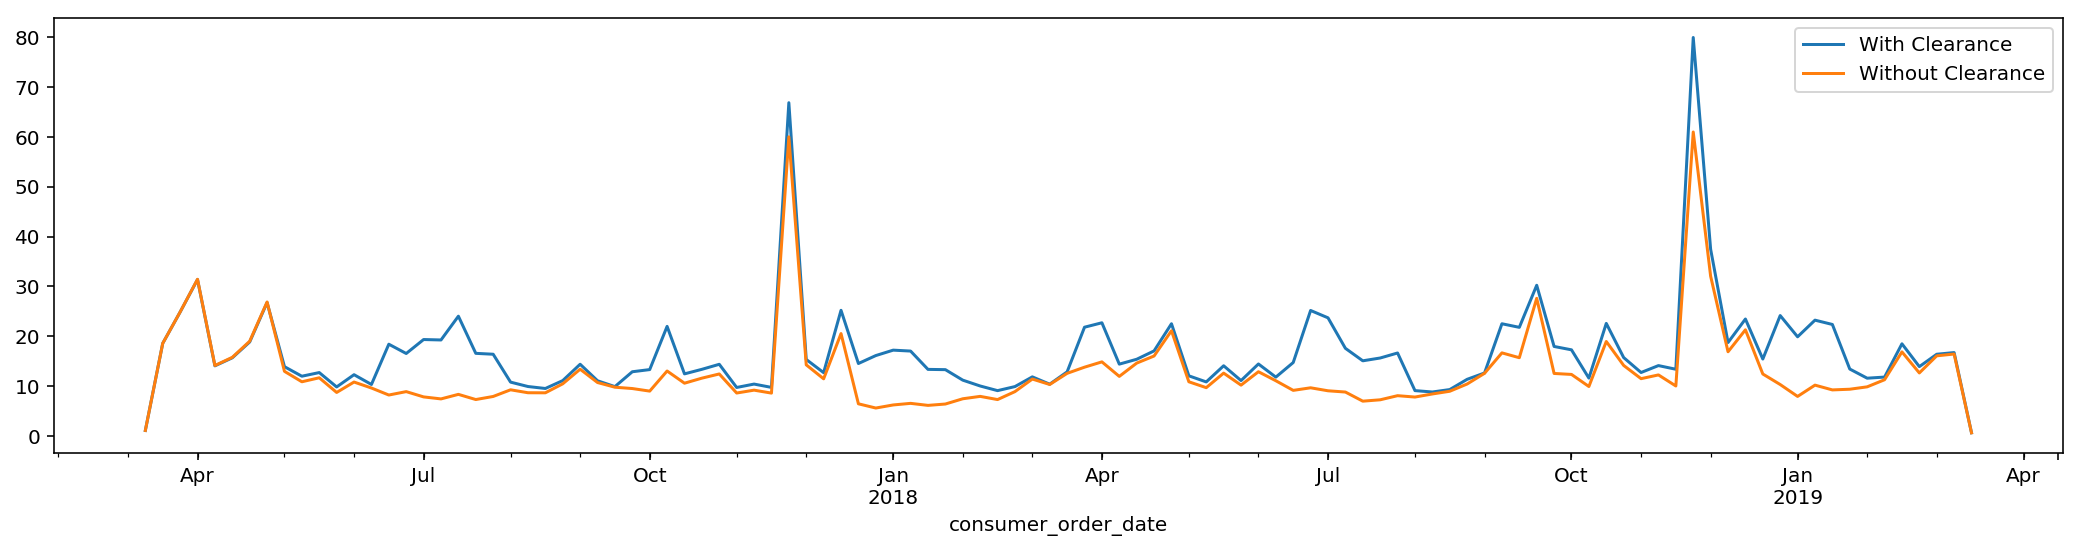

In [50]:
# With/without Clearance weekly average net_qty 
plt.rcParams["figure.figsize"] = [18,4]
dat_both.plot()


In [54]:
# %whos DataFrame 

dat.head()

,consumer_order_date,article_number,net_qty,season,clearance
0,2017-03-13,002214,0,SS17,False
1,2017-03-13,002214,1,SS17,False
2,2017-03-13,002214,1,SS17,False
3,2017-03-14,002214,1,SS17,False
4,2017-03-15,002214,1,SS17,False


In [53]:
dat